In [1]:
import os
from dotenv import load_dotenv

_ = load_dotenv()

Based on : https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/multi_agent/hierarchical_agent_teams.ipynb

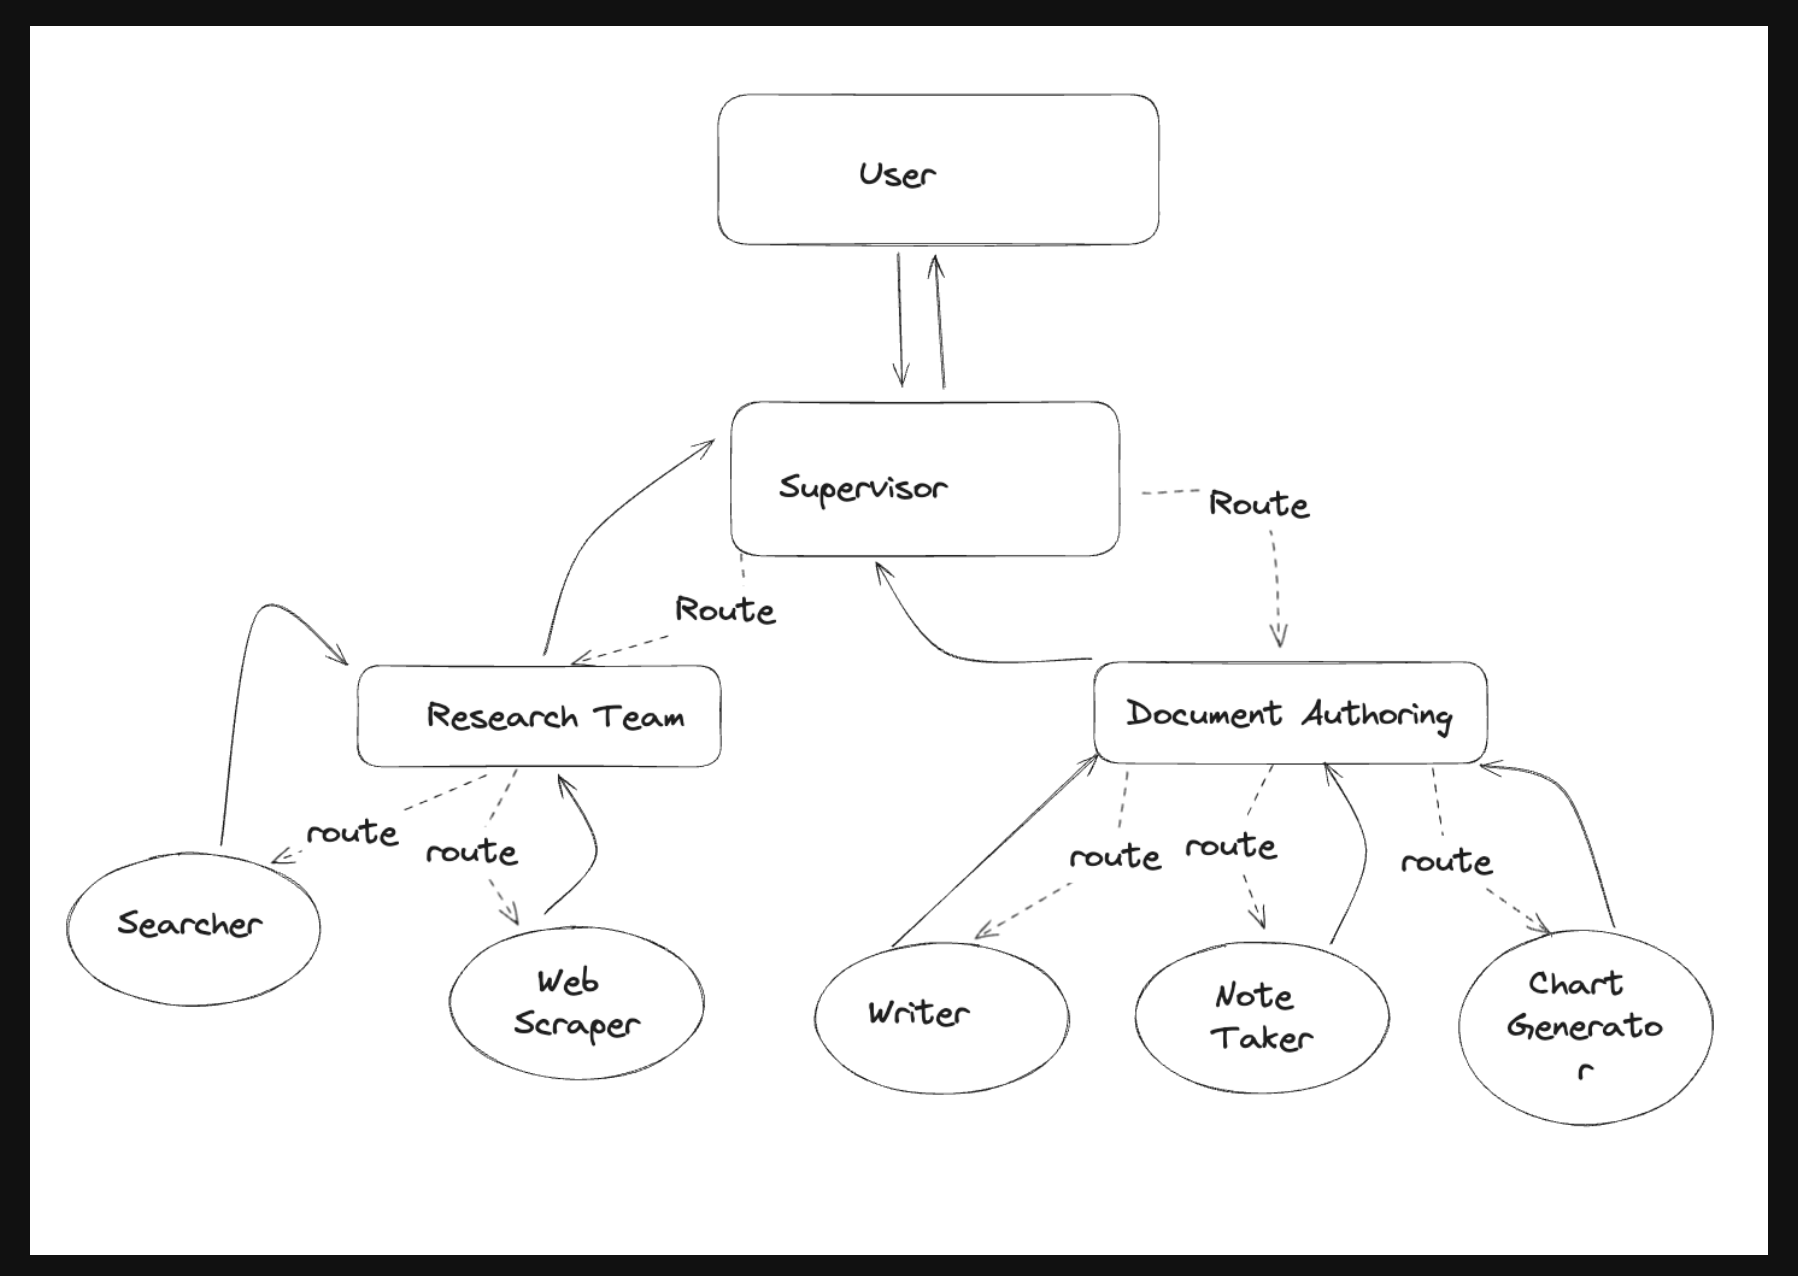

In [2]:
from IPython.display import Image
Image(filename='./assets/hierarchical_teams.png')


## Research Team Tools

In [3]:
# Tools
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

USER_AGENT environment variable not set, consider setting it to identify your requests.


## Document Writing Tools

In [4]:
from pathlib import Path
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

WORKING_DIRECTORY = Path("./workspace")
WORKING_DIRECTORY.mkdir(exist_ok=True)

print(WORKING_DIRECTORY)

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File name for the markdown outline (will append .md if needed)."],
) -> Annotated[str, "Path of the saved markdown outline."]:
    """Create and save an outline in markdown format."""
    # Ensure file has .md extension
    if not file_name.endswith('.md'):
        file_name += '.md'
    
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write("# Outline\n\n")  # Add markdown header
        for i, point in enumerate(points):
            file.write(f"## {i + 1}. {point}\n")
    return f"Markdown outline saved to {file_name}"

@tool
def read_document(
    file_name: Annotated[str, "File name of the markdown document (will append .md if needed)."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified markdown document."""
    if not file_name.endswith('.md'):
        file_name += '.md'
    
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "".join(lines[start:end])

@tool
def write_document(
    content: Annotated[str, "Markdown content to be written into the document."],
    file_name: Annotated[str, "File name for the markdown document (will append .md if needed)."],
) -> Annotated[str, "Path of the saved markdown document."]:
    """Create and save a markdown document."""
    if not file_name.endswith('.md'):
        file_name += '.md'
    
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Markdown document saved to {file_name}"

@tool
def edit_document(
    file_name: Annotated[str, "Name of the markdown document to be edited (will append .md if needed)."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the markdown text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited markdown document."]:
    """Edit a markdown document by inserting text at specific line numbers."""
    if not file_name.endswith('.md'):
        file_name += '.md'

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            # Ensure the inserted text ends with a newline
            if not text.endswith('\n'):
                text += '\n'
            lines.insert(line_number - 1, text)
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Markdown document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

workspace


## Utilities

In [5]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages


class State(MessagesState):
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

# Define Agent Teams

# Research

In [6]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o-2024-08-06")

search_agent = create_react_agent(llm, tools=[tavily_tool])


def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])


def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

In [7]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

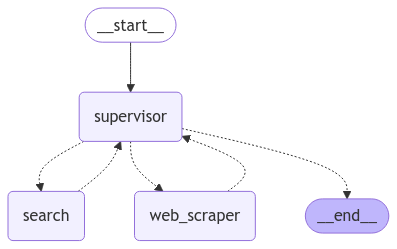

In [8]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [9]:
for s in research_graph.stream(
    {"messages": [("user", "when is Taylor Swift's next tour?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='Taylor Swift\'s "The Eras Tour" began in March 2023 and is scheduled to continue into 2024. The tour is set to conclude on November 23, 2024, in Toronto, Canada. It includes international stops in various countries such as Japan, Australia, Singapore, France, Sweden, Portugal, Spain, Ireland, the Netherlands, Switzerland, Italy, Germany, Poland, and Austria, along with many dates in the United Kingdom.', additional_kwargs={}, response_metadata={}, name='search', id='cb0ce597-439f-4a4f-aa35-1a19eaa3a1d4')]}}
---
{'supervisor': {'next': '__end__'}}
---


# Writing Team

In [10]:
llm = ChatOpenAI(model="gpt-4o-2024-08-06")

doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)


def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

In [11]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

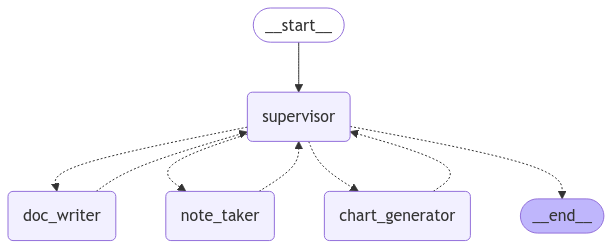

In [12]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [13]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about cats and then write the poem to disk.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [HumanMessage(content='The poem based on the outline is written and saved as "ode_to_the_feline.md".', additional_kwargs={}, response_metadata={}, name='doc_writer', id='57656e5d-fb1d-475a-9808-949b12010a35')]}}
---
{'supervisor': {'next': 'note_taker'}}
---
{'note_taker': {'messages': [HumanMessage(content='I have created the outline for the poem about cats and saved it as "ode_to_the_feline_outline.md".', additional_kwargs={}, response_metadata={}, name='note_taker', id='9d7ba48a-d96b-45f9-a09d-5e572b0fce17')]}}
---
{'supervisor': {'next': '__end__'}}
---


## Add Layers

In [14]:
from langchain_core.messages import BaseMessage

llm = ChatOpenAI(model="gpt-4o-2024-08-06")

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [15]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )


# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

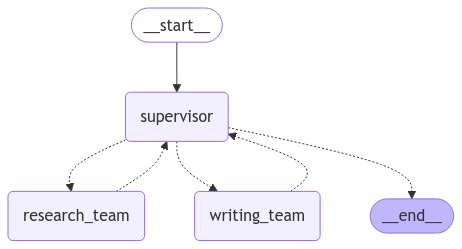

In [16]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [17]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Write a brief report titled China Economy Report considering that current year is 2025.")
        ],
    },
    {"recursion_limit": 150},
    subgraphs=True,
):
    print(s)
    print("---")

((), {'supervisor': {'next': 'research_team'}})
---
(('research_team:d0deafb7-fe10-8478-2e84-d3a64d66ffa4',), {'supervisor': {'next': 'search'}})
---
(('research_team:d0deafb7-fe10-8478-2e84-d3a64d66ffa4', 'search:6a833da5-9970-e826-044f-4d7f197e9d39'), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LB7kWsOqMPyB9MN4jzfZIKc1', 'function': {'arguments': '{"query":"China economy report 2025"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 96, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f9f4fb6dbf', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3c80b809-388f-4908-aca3-0da35f375c8f-0',